In [8]:
from sklearn.metrics import f1_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

In [9]:
# train_data = np.load('dataset/train_split.npy', allow_pickle=True).item()
# val_data = np.load('dataset/val_split.npy', allow_pickle=True).item()

In [10]:
train_data = np.load('train_split.npy', allow_pickle=True).item()
val_data = np.load('val_split.npy', allow_pickle=True).item()

In [11]:
train_data['sequences']['283a94cc8e']['keypoints'].shape[0]

1283

In [12]:
# train data processing
train_features = []
train_labels = []
window_size = 5

for sequence in train_data['sequences'].values():
    keypoints = sequence['keypoints']
    annotations = sequence['annotations']

    num_frames = keypoints.shape[0]
    for i in range(num_frames - window_size + 1):
        window = keypoints[i:i+window_size]
        window_flat = window.reshape(-1)
        label = annotations[i + window_size - 1]

        train_features.append(window_flat)
        train_labels.append(label)

train_features = np.array(train_features)
train_labels = np.array(train_labels)


print(train_features.shape)
print(train_labels.shape)


(426395, 140)
(426395,)


In [13]:
# validation data processing
val_features = []
val_labels = []
window_size = 5

for sequence in val_data['sequences'].values():
    keypoints = sequence['keypoints']
    annotations = sequence['annotations']

    num_frames = keypoints.shape[0]
    for i in range(num_frames - window_size + 1):
        window = keypoints[i:i+window_size]  # shape: (10, feature_dim)
        window_flat = window.reshape(-1)     # shape: (10 * feature_dim,)
        label = annotations[i + window_size - 1]  # label of the last frame in the window

        val_features.append(window_flat)
        val_labels.append(label)

val_features = np.array(val_features)
val_labels = np.array(val_labels)


print(val_features.shape)
print(val_labels.shape)

(81063, 140)
(81063,)


In [14]:
class FC_classifier(nn.Module):
    def __init__(self, input_dim):
        super(FC_classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [15]:
def validation(model, val_features, val_labels, device='cuda' if torch.cuda.is_available() else 'cpu'):
    X = torch.tensor(val_features, dtype=torch.float32)
    y = torch.tensor(val_labels, dtype=torch.long)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    model = model.to(device)
    model.eval()

    total_predictions = 0
    correct_predictions = 0
    labels = []
    total_predicted = []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.view(batch_X.size(0), -1)
            outputs = model(batch_X)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
            labels = labels + batch_y.tolist()
            total_predicted = total_predicted + predicted.tolist()
    accuracy = 100 * correct_predictions / total_predictions
    F1 = f1_score(labels, total_predicted, average='macro', labels=[0, 1, 2])
    print(f"Val-F1: {F1:.4f}")
    return accuracy, F1

In [19]:
def train_model(model, train_features, train_labels, epochs=10, batch_size=256, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    X = torch.tensor(train_features, dtype=torch.float32)
    y = torch.tensor(train_labels, dtype=torch.long)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # weight = label_weight(train_labels)
    weight = torch.tensor([1, 1, 1, 1], dtype=torch.float32)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)

    train_accuracies = []
    train_f1s = []
    val_accuracies = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_predictions = 0
        correct_predictions = 0
        labels = []
        total_predicted = []
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.view(batch_X.size(0), -1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
            total_loss += loss.item() * batch_X.size(0)
            labels = labels + batch_y.tolist()
            total_predicted = total_predicted + predicted.tolist()

        avg_loss = total_loss / len(dataset)
        accuracy = 100 * correct_predictions / total_predictions
        F1 = f1_score(labels, total_predicted, average='macro', labels=[0, 1, 2])
        print(f"Epoch {epoch+1}/{epochs} - Train-Loss: {avg_loss:.4f} - Train-Accuracy: {accuracy:.2f}% - Train-F1: {F1:.4f}")
        train_accuracies.append(accuracy)
        train_f1s.append(F1)

        val_accuracy,val_f1= validation(model, val_features, val_labels, device='cuda' if torch.cuda.is_available() else 'cpu')
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
    print("Training complete.")
    return model, train_accuracies, train_f1s, val_accuracies, val_f1s

In [20]:
input_dim = 140
model = FC_classifier(input_dim=input_dim)
model, train_accuracies, train_f1s, val_accuracies, val_f1s = train_model(model, train_features, train_labels, epochs=30, batch_size=256, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1/30 - Train-Loss: 0.4904 - Train-Accuracy: 82.33% - Train-F1: 0.4503
Val-F1: 0.5156
Epoch 2/30 - Train-Loss: 0.3784 - Train-Accuracy: 86.23% - Train-F1: 0.5364
Val-F1: 0.5332
Epoch 3/30 - Train-Loss: 0.3618 - Train-Accuracy: 86.83% - Train-F1: 0.5587
Val-F1: 0.5822
Epoch 4/30 - Train-Loss: 0.3492 - Train-Accuracy: 87.29% - Train-F1: 0.5771
Val-F1: 0.6277
Epoch 5/30 - Train-Loss: 0.3374 - Train-Accuracy: 87.70% - Train-F1: 0.5987
Val-F1: 0.5518
Epoch 6/30 - Train-Loss: 0.3308 - Train-Accuracy: 87.96% - Train-F1: 0.6103
Val-F1: 0.5493
Epoch 7/30 - Train-Loss: 0.3229 - Train-Accuracy: 88.25% - Train-F1: 0.6256
Val-F1: 0.5532
Epoch 8/30 - Train-Loss: 0.3182 - Train-Accuracy: 88.34% - Train-F1: 0.6355
Val-F1: 0.5557
Epoch 9/30 - Train-Loss: 0.3122 - Train-Accuracy: 88.56% - Train-F1: 0.6478
Val-F1: 0.5514
Epoch 10/30 - Train-Loss: 0.3077 - Train-Accuracy: 88.66% - Train-F1: 0.6580
Val-F1: 0.5377
Epoch 11/30 - Train-Loss: 0.3033 - Train-Accuracy: 88.81% - Train-F1: 0.6615
Val-F1: 0.54

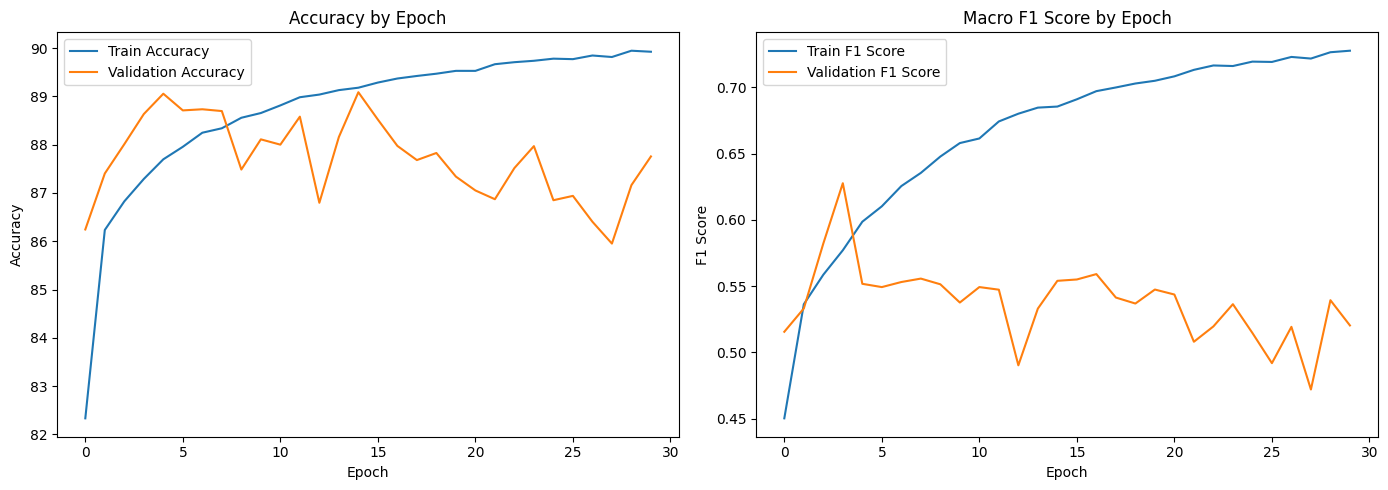

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy by Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.title("Macro F1 Score by Epoch")
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
